# Project 3 / Iowa Liquor Sales

Source: [Iowa Liquor Sales](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) 

#### Goal: Find locations to open a new liquor store.

## Step 1: Import the Data and Packages

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Load the data
df = pd.read_csv("data/Iowa_Liquor_sales_sample_10pct.csv")
print df.columns
df.head()

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'State Bottle Cost', u'State Bottle Retail', u'Bottles Sold',
       u'Sale (Dollars)', u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


## Step 2: Clean the data

In [3]:
# Remove redundant columns
del df["Category Name"]
del df["Item Description"]
del df["County"]

# Remove $ from certain columns
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in cols:
    df[col] = df[col].apply(lambda x: float(x[1:]))
    
# Convert dates
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

# Drop or replace bad values
df = df.dropna()

# Convert integers
df["County Number"] = df["County Number"].astype(int)
df["Category"] = df["Category"].astype(int)
df["Store Number"] = df["Store Number"].astype(int)

# Create new columns
df["Profit"] = (df["State Bottle Retail"] - df["State Bottle Cost"]) * df['Bottles Sold']
df["Cost"] = df["State Bottle Cost"] * df["Bottles Sold"]
df["Price Per Bottle"] = df["Sale (Dollars)"] / df["Bottles Sold"] 
df["Price Per Liter"] = df["Sale (Dollars)"] / df["Volume Sold (Liters)"]
df["Profit Per Liter"] = df["Profit"] / df["Volume Sold (Liters)"]
df["Month"] = df["Date"].map(lambda x: x.month)
df["Day"] = df["Date"].map(lambda x: x.day)
df["Year"] = df["Date"].map(lambda x: x.year)

df.head()

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,...,Volume Sold (Liters),Volume Sold (Gallons),Profit,Cost,Price Per Bottle,Price Per Liter,Profit Per Liter,Month,Day,Year
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,...,9.0,2.38,27.00,54.00,6.75,9.000000,3.000000,11,4,2015
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,...,1.5,0.40,13.76,27.50,20.63,27.506667,9.173333,3,2,2016
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,...,24.0,6.34,151.20,302.16,18.89,18.890000,6.300000,2,11,2016
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,...,10.5,2.77,28.50,57.00,14.25,8.142857,2.714286,2,3,2016
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,...,21.0,5.55,43.20,86.40,10.80,6.171429,2.057143,8,18,2015


## Step 3: Exploratory Data Analysis

#### Sales per store, 2015

In [4]:
# Filter by start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

# Group by store name
sales = sales.groupby(by=["Store Number"], as_index=False)
# Compute sums, means
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Cost": np.sum,
                   "Profit": np.sum,
                   "Price Per Bottle": np.mean,
                   "Price Per Liter": np.mean,
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0],
                   "Profit Per Liter": np.sum})
# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]

# Rename the columns
sales.rename(columns=lambda x: x.replace('Volume Sold (Liters) sum', 'Total Volume Sold (Liters)'), inplace=True)
sales.rename(columns=lambda x: x.replace('Volume Sold (Liters) mean', 'Average Volume Sold (Liters)'), inplace=True)
sales.rename(columns=lambda x: x.replace('City <lambda>', 'City'), inplace=True)
sales.rename(columns=lambda x: x.replace('Sale (Dollars) sum', 'Revenue'), inplace=True)
sales.rename(columns=lambda x: x.replace('Sale (Dollars) mean', 'Average Sale (Dollars)'), inplace=True)
sales.rename(columns=lambda x: x.replace('Cost sum', 'Cost'), inplace=True)
sales.rename(columns=lambda x: x.replace('Price Per Bottle mean', 'Average Price Per Bottle'), inplace=True)
sales.rename(columns=lambda x: x.replace('Profit sum', 'Profit'), inplace=True)
sales.rename(columns=lambda x: x.replace('County Number <lambda>', 'County Number'), inplace=True)
sales.rename(columns=lambda x: x.replace('Price Per Liter mean', 'Average Price Per Liter'), inplace=True)
sales.rename(columns=lambda x: x.replace('Zip Code <lambda>', 'Zip Code'), inplace=True)
sales.rename(columns=lambda x: x.replace('Profit Per Liter sum', 'Profit Per Liter'), inplace=True)

sales.head()

,Store Number,Total Volume Sold (Liters),Average Volume Sold (Liters),City,Cost,Revenue,Average Sale (Dollars),Average Price Per Bottle,Profit Per Liter,Profit,County Number,Average Price Per Liter,Zip Code
0,2106,9731.85,18.466509,CEDAR FALLS,97488.14,146326.22,277.658861,15.475863,3141.451190,48838.08,7,17.856601,50613
1,2113,659.85,4.488776,GOWRIE,6201.18,9310.22,63.334830,16.315646,907.563333,3109.04,94,18.507700,50543
2,2130,6891.37,17.580026,WATERLOO,74546.23,111871.43,285.386301,14.764286,2201.842143,37325.20,7,16.835809,50703
3,2152,633.37,4.491986,ROCKWELL,5133.55,7721.08,54.759433,12.887660,614.545883,2587.53,17,13.020765,50469
4,2178,1917.12,8.089114,WAUKON,16158.48,24324.18,102.633671,14.558692,1271.498031,8165.70,3,16.053844,52172


#### Q1 Sales in 2015

In [5]:
# Filter data from January 1st 2015 to March 31st 2015
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
q1_sales_2015 = df[mask]

# Group by store name
q1_sales_2015 = q1_sales_2015.groupby(by=["Store Number"], as_index=False)
# Compute sums
q1_sales_2015 = q1_sales_2015.agg({"Sale (Dollars)": np.sum})
# Collapse the column indices
q1_sales_2015.columns = [' '.join(col).strip() for col in q1_sales_2015.columns.values]

# Rename the columns
q1_sales_2015.rename(columns=lambda x: x.replace('S t o r e   N u m b e r', 'Store Number'), inplace=True)
q1_sales_2015.rename(columns=lambda x: x.replace('S a l e   ( D o l l a r s )', 'Q1 Revenue (2015)'), inplace=True)

# Merge with Sales dataframe
sales = pd.merge(sales, q1_sales_2015, on='Store Number', how='right')

#### Q2 Sales 2015 

In [6]:
# Filter data from April 1st, 2015 to June 30th, 2015
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150401")
end_date = pd.Timestamp("20150630")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
q2_sales_2015 = df[mask]

# Group by store name
q2_sales_2015 = q2_sales_2015.groupby(by=["Store Number"], as_index=False)
# Compute sums
q2_sales_2015 = q2_sales_2015.agg({"Sale (Dollars)": np.sum})
# Collapse the column indices
q2_sales_2015.columns = [' '.join(col).strip() for col in q2_sales_2015.columns.values]

# Rename the columns
q2_sales_2015.rename(columns=lambda x: x.replace('S t o r e   N u m b e r', 'Store Number'), inplace=True)
q2_sales_2015.rename(columns=lambda x: x.replace('S a l e   ( D o l l a r s )', 'Q2 Revenue (2015)'), inplace=True)

# Merge with Sales dataframe
sales = pd.merge(sales, q2_sales_2015, on='Store Number', how='right')

#### Q3 Sales in 2015

In [7]:
# Filter data from July 1st, 2015 to September 30th, 2015
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150701")
end_date = pd.Timestamp("20150930")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
q3_sales_2015 = df[mask]

# Group by store name
q3_sales_2015 = q3_sales_2015.groupby(by=["Store Number"], as_index=False)
# Compute sums
q3_sales_2015 = q3_sales_2015.agg({"Sale (Dollars)": np.sum})
# Collapse the column indices
q3_sales_2015.columns = [' '.join(col).strip() for col in q3_sales_2015.columns.values]

# Rename the columns
q3_sales_2015.rename(columns=lambda x: x.replace('S t o r e   N u m b e r', 'Store Number'), inplace=True)
q3_sales_2015.rename(columns=lambda x: x.replace('S a l e   ( D o l l a r s )', 'Q3 Revenue (2015)'), inplace=True)

# Merge with Sales dataframe
sales = pd.merge(sales, q3_sales_2015, on='Store Number', how='right')

#### Q4 Sales in 2015

In [8]:
# Filter data from October 1st, 2015 to December 31st, 2015
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20151001")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
q4_sales_2015 = df[mask]

# Group by store name
q4_sales_2015 = q4_sales_2015.groupby(by=["Store Number"], as_index=False)
# Compute sums
q4_sales_2015 = q4_sales_2015.agg({"Sale (Dollars)": np.sum})
# Collapse the column indices
q4_sales_2015.columns = [' '.join(col).strip() for col in q4_sales_2015.columns.values]

# Rename the columns
q4_sales_2015.rename(columns=lambda x: x.replace('S t o r e   N u m b e r', 'Store Number'), inplace=True)
q4_sales_2015.rename(columns=lambda x: x.replace('S a l e   ( D o l l a r s )', 'Q4 Revenue (2015)'), inplace=True)

# Merge with Sales dataframe
sales = pd.merge(sales, q4_sales_2015, on='Store Number', how='right')

#### Q1 Sales in 2016

In [9]:
# Filter data from January 1st 2016 to March 31st, 2016
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
q1_sales_2016 = df[mask]

# Group by store name
q1_sales_2016 = q1_sales_2016.groupby(by=["Store Number"], as_index=False)
# Compute sums, means
q1_sales_2016 = q1_sales_2016.agg({"Sale (Dollars)": np.sum})
# Collapse the column indices
q1_sales_2016.columns = [' '.join(col).strip() for col in q1_sales_2016.columns.values]

# Rename the columns
q1_sales_2016.rename(columns=lambda x: x.replace('S t o r e   N u m b e r', 'Store Number'), inplace=True)
q1_sales_2016.rename(columns=lambda x: x.replace('S a l e   ( D o l l a r s )', 'Q1 Revenue (2016)'), inplace=True)

# Merget with Sales dataframe
sales = pd.merge(sales, q1_sales_2016, on='Store Number', how='right')

#### Let's see our Sales dataframe

In [10]:
sales.head()

,Store Number,Total Volume Sold (Liters),Average Volume Sold (Liters),City,Cost,Revenue,Average Sale (Dollars),Average Price Per Bottle,Profit Per Liter,Profit,County Number,Average Price Per Liter,Zip Code,Q1 Revenue (2015),Q2 Revenue (2015),Q3 Revenue (2015),Q4 Revenue (2015),Q1 Revenue (2016)
0,2106.0,9731.85,18.466509,CEDAR FALLS,97488.14,146326.22,277.658861,15.475863,3141.451190,48838.08,7.0,17.856601,50613,39287.29,31173.46,38324.77,37540.70,30523.75
1,2113.0,659.85,4.488776,GOWRIE,6201.18,9310.22,63.334830,16.315646,907.563333,3109.04,94.0,18.507700,50543,2833.25,1994.30,2113.56,2369.11,2065.90
2,2130.0,6891.37,17.580026,WATERLOO,74546.23,111871.43,285.386301,14.764286,2201.842143,37325.20,7.0,16.835809,50703,24272.57,35038.09,24605.88,27954.89,27856.11
3,2152.0,633.37,4.491986,ROCKWELL,5133.55,7721.08,54.759433,12.887660,614.545883,2587.53,17.0,13.020765,50469,2003.46,1398.92,2246.70,2072.00,904.66
4,2178.0,1917.12,8.089114,WAUKON,16158.48,24324.18,102.633671,14.558692,1271.498031,8165.70,3.0,16.053844,52172,5856.41,6986.33,5668.15,5813.29,5588.50


### 2015 Sales Pivot Table

In [11]:
sales_15 = pd.pivot_table(sales, index=['City', 'Zip Code', 'Store Number'],
                              values = ['Revenue',
                                        'Profit',
                                        'Cost',
                                        'Average Sale (Dollars)',
                                        'Average Price Per Bottle',
                                        'Average Price Per Liter', 
                                        'Average Volume Sold (Liters)',
                                        'Total Volume Sold (Liters)',
                                        'Q1 Revenue (2015)',
                                        'Q2 Revenue (2015)',
                                        'Q3 Revenue (2015)',
                                        'Q4 Revenue (2015)',
                                        'Profit Per Liter'],
                              aggfunc=sum,
                              margins = True)

sales_15.head(10)

Average Price Per Bottle  \
City   Zip Code Store Number                             
ACKLEY 50601    4415.0                       12.635122   
ADAIR  50002    4417.0                       12.731250   
ADEL   50003    4384.0                       11.168800   
                4678.0                       12.985000   
AFTON  50830    4531.0                       11.062000   
AKRON  51001    4525.0                       12.258393   
ALBIA  52531    2559.0                       13.603259   
                4011.0                       13.944671   
ALDEN  50006    4172.0                       18.074615   
ALGONA 50511    2585.0                       15.128298   

                              Average Price Per Liter  Average Sale (Dollars)  \
City   Zip Code Store Number                                                    
ACKLEY 50601    4415.0                      16.907684               79.978293   
ADAIR  50002    4417.0                      16.173294              145.122500   
ADEL   50003    4384.0                      17.096152               73.062100   
                4678.0                      14.946038              204.464257   
AFTON  50830    4531.0                      18.366286              272.376000   
AKRON  51001    4525.0                      17.007670               77.058750   
ALBIA  52531    2559.0                      15.722674               89.057407   
                4011.0                      16.829839              108.931908   
ALDEN  50006    4172.0                      16.581137               99.250659   
ALGONA 50511    2585.0                      16.840861              135.537094   

                              Average Volume Sold (Liters)      Cost  \
City   Zip Code Store Number                                           
ACKLEY 50601    4415.0                            6.828780   2178.72   
ADAIR  50002    4417.0                            9.375000   2311.40   
ADEL   50003    4384.0                            5.963100   4862.35   
                4678.0                           14.163581  20146.30   
AFTON  50830    4531.0                           21.450000   1811.28   
AKRON  51001    4525.0                            6.131786   2868.35   
ALBIA  52531    2559.0                            6.511111   7984.78   
                4011.0                            7.711645  11030.97   
ALDEN  50006    4172.0                            6.914725   6013.92   
ALGONA 50511    2585.0                           10.379503  47132.24   

                                Profit  Profit Per Liter  Q1 Revenue (2015)  \
City   Zip Code Store Number                                                  
ACKLEY 50601    4415.0         1100.39        231.530138            1064.46   
ADAIR  50002    4417.0         1171.54        130.460000             731.52   
ADEL   50003    4384.0         2443.86        570.826310            2126.68   
                4678.0        10114.41        739.050476            9189.13   
AFTON  50830    4531.0          912.48         61.455238             729.12   
AKRON  51001    4525.0         1446.94        317.936071            1249.34   
ALBIA  52531    2559.0         4037.97        710.816190            2683.86   
                4011.0         5526.68        853.604850            4273.14   
ALDEN  50006    4172.0         3017.89        504.049286            2448.60   
ALGONA 50511    2585.0        23753.66       2944.130327            9330.01   

                              Q2 Revenue (2015)  Q3 Revenue (2015)  \
City   Zip Code Store Number                                         
ACKLEY 50601    4415.0                   806.48             495.38   
ADAIR  50002    4417.0                   726.90            1074.78   
ADEL   50003    4384.0                  1949.15            1210.46   
                4678.0                  5115.10           11092.01   
AFTON  50830    4531.0                   661.80             564.48   
AKRON  51001    4525.0                  1045.24         

This Sales Pivot Table aggregates the most important liquor sales information in Iowa in 2015. It is indexed by City, Zip Code, and Store Number and may be useful later on as a reference if we want to look up sales for a specific location (City or Zip Code) or Store Number.

### Which months sold the most liquor?

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


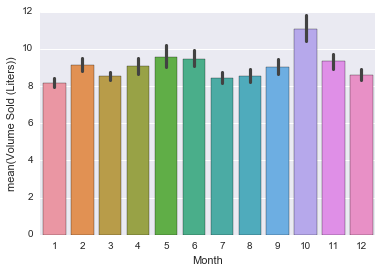

In [12]:
sns.barplot(data = df, x="Month", y="Volume Sold (Liters)")

### Which areas sell the most liquor and make the most profit?

To answer this question, I will be using the column, "Profit Per Liter" as the main feature. I calculated "Profit Per Liter" from my "Profit" and "Volume Sold (Liters)" columns. In the cells below, I will use a groupby function to find the best locations by "City", "Zip Code", and "Store Number".

#### Top 10 Cities

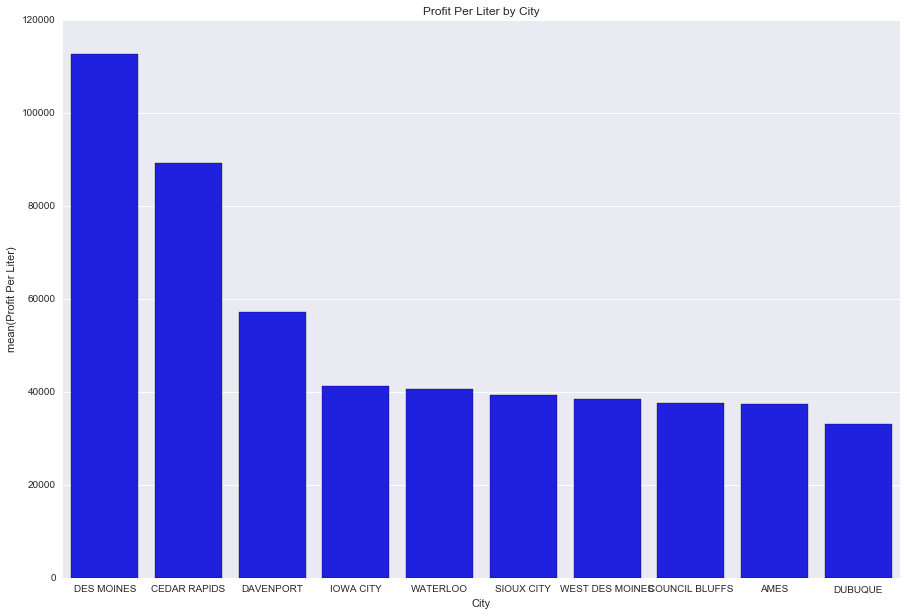

In [13]:
profit_city = sales.groupby("City", as_index=False)["Profit Per Liter"].sum()
profit_city = profit_city.sort_values("Profit Per Liter", ascending=False).head(10)

plt.figure(figsize=(15,10))
sns.barplot(x=profit_city["City"], 
            y=profit_city['Profit Per Liter'],
            color='b').set(title='Profit Per Liter by City')

By looking at "Profit Per Liter", we can see that the Top 10 Cities in Iowa that make the most profit selling the most liquor are:
    1. Des Moines
    2. Cedar Rapids
    3. Davenport
    4. Iowa City
    5. Waterloo
    6. Sioux City
    7. West Des Moines
    8. Council Bluffs
    9. Ames
    10. Dubuque

#### Top 10 Zip Codes

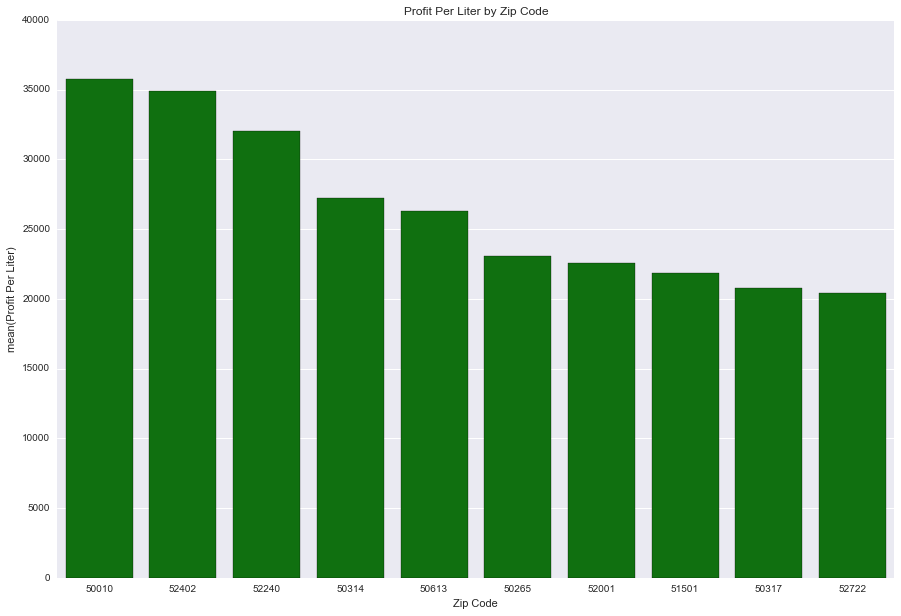

In [14]:
profit_zip_code = sales.groupby("Zip Code", as_index=False)["Profit Per Liter"].sum()
profit_zip_code = profit_zip_code.sort_values('Profit Per Liter', ascending=False).head(10)

plt.figure(figsize=(15,10))
sns.barplot(x=profit_zip_code["Zip Code"],
            y=profit_zip_code['Profit Per Liter'], 
            color='g').set(title='Profit Per Liter by Zip Code')

By looking at "Profit Per Liter", we can see that the Top 10 Zip Codes that make the most profit selling the most liquor are:
    1. 50010
    2. 52402
    3. 52240
    4. 50314
    5. 50613
    6. 50265
    7. 52001
    8. 51501
    9. 50317
    10. 52722

#### Top 10 Stores

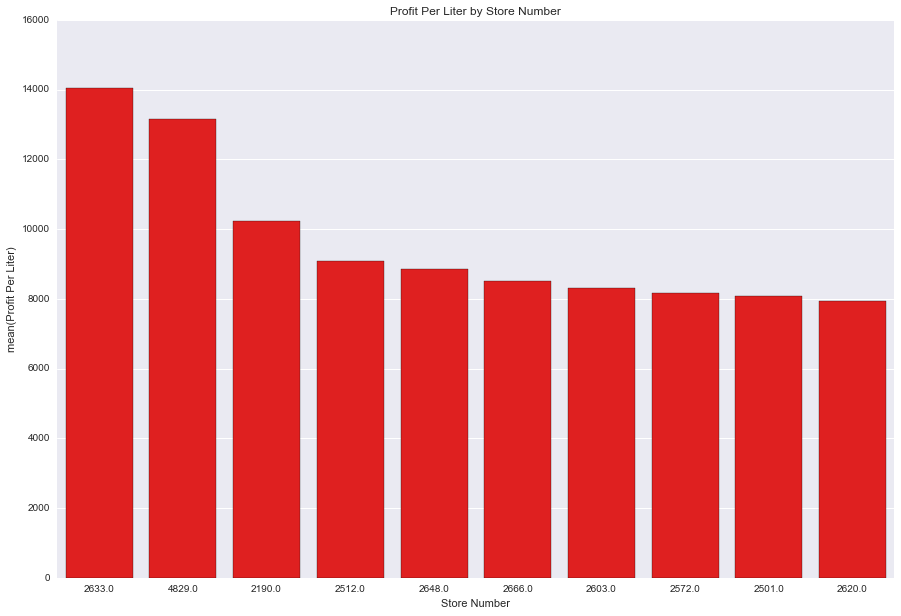

In [15]:
profit_store = sales.groupby("Store Number", as_index=False)["Profit Per Liter"].sum()
profit_store = profit_store.sort_values("Profit Per Liter", ascending=False).head(10)

plt.figure(figsize=(15,10))
sns.barplot(x=profit_store["Store Number"], 
            y=profit_store['Profit Per Liter'],
            color='r').set(title='Profit Per Liter by Store Number')

By looking at "Profit Per Liter", we can see that the Top 10 Stores that make the most profit selling liquor are:
    1. 2633 
    2. 4829
    3. 2190
    4. 2512
    5. 2648
    6. 2666
    7. 2603
    8. 2572
    9. 2501
    10. 2620

## Step 4: Develop Models for Prediction

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

#### Remove NaNs and Impute Data

In [17]:
sales = sales.fillna(method='ffill')

### Linear Regression: Predict Q1 Sales in 2016

In [18]:
# Dependent Variable
y = sales["Q1 Revenue (2016)"]

# Independent Variables
X = sales[["Q1 Revenue (2015)",
           "Q2 Revenue (2015)",
           "Q3 Revenue (2015)",
           "Q4 Revenue (2015)"]]

# Split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

# Scale the data on the train/test separately
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform linear regression
LR = LinearRegression()
LR.fit(X_train, y_train)
print "R-squared Score (in-sample):", LR.score(X_train, y_train)
print "R-squared Score (out-of-sample):", LR.score(X_test, y_test)

R-squared Score (in-sample): 0.929870459243
R-squared Score (out-of-sample): 0.957967547683


#### Intercept and Coefficients

In [19]:
print "Intercept:", LR.intercept_
print "Coefficient:", LR.coef_

Intercept: 5111.34301042
Coefficient: [ -406.54850042  4785.61052523  4106.82926921  2743.2107594 ]


#### Projection

In [20]:
sales['Projected Q1 Revenue (2016)'] = 5111.34301042 \
                                        + (-406.54850042 * sales['Q1 Revenue (2015)']) \
                                        + (4785.61052523 * sales['Q2 Revenue (2015)']) \
                                        + (4106.82926921 * sales['Q3 Revenue (2015)']) \
                                        + (2743.2107594 * sales['Q4 Revenue (2015)'])

#### Visualize

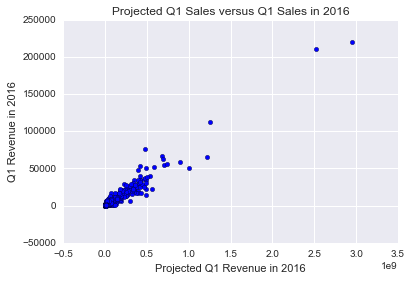

In [21]:
plt.scatter(sales['Projected Q1 Revenue (2016)'], sales['Q1 Revenue (2016)'])
plt.title("Projected Q1 Sales versus Q1 Sales in 2016")
plt.xlabel("Projected Q1 Revenue in 2016")
plt.ylabel("Q1 Revenue in 2016")
plt.show()

#### Results

Using a standard linear regression, I was able to create a model in which I could forecast Q1 sales in 2016. With the R-squared scores (in-sample) at 0.9298 and (out-of-sample) at 0.9579, I was confident my model made an accurate forecast for 2016. A visualization of my projection compared to the actual Q1 sales in 2016 also confirms a relatively accurate prediction.

## Step 5: Conclusion

### Final Recommendations

#### 1. Build a liquor store in a Top 10 City or Zip Code based on Profit Per Liter

In my exploratory data analysis, I used "Profit Per Liter" as my main feature to find top cities, zip codes, and stores that were the most profitable selling the most liquor. I found that "Profit Per Liter" would be best for any new store owner, as it would show liquor sales not only based on total sales, but also total volume. This should be important for new store owners who do not cannot yet afford a large inventory of liquor.

#### 2. Model your liquor store after Store #2633 and Store #4829

After visualizing my data, I concluded that two stores outperformed other stores in the study. In building a new liquor store, a new store owner should look to these two stores as models. More investigation should be performed to understand why these two stores are selling so well, but learning from these stores should be the first step in starting a new liquor store.

#### 3. Quarterly Sales Will Predict Future Sales

In my projection, I found that quarterly sales were able to predict future sales. While this is nothing new, this may help to explain the demand for liquor during the season as well as peaks/troughs in the economy. More data and investigation will be required to make a more detailed projection. Adding to and enriching the dataset with new data will also help create a more complex model. 